In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import plotly.graph_objects as go

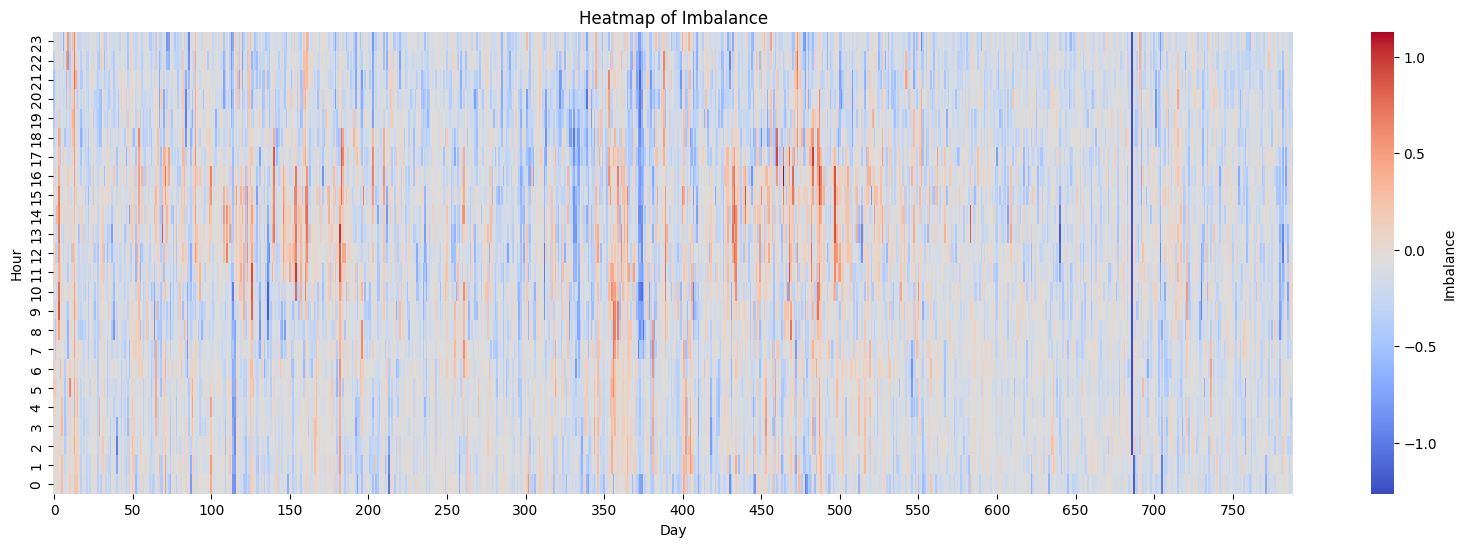

In [2]:
X = np.load("../data/X.npy")

condition = X[:, :3, :]
target = X[:, 3, :]

cond_tensor = torch.tensor(condition, dtype=torch.float32)
target_tensor = torch.tensor(target, dtype=torch.float32)

dataset = TensorDataset(cond_tensor, target_tensor)

cond_dim = 3 * 24
target_dim = 24
latent_dim = 16

n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train
train_dataset, val_dataset = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_dataset, batch_size=2**8, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=2**8, shuffle=False)


plt.figure(figsize=(20, 6))
ax = sns.heatmap(target.T, cmap='coolwarm', cbar_kws={'label': 'Imbalance'}, xticklabels=50)
ax.set_xlabel("Day")
ax.set_ylabel("Hour")
plt.title("Heatmap of Imbalance")
plt.gca().invert_yaxis()
plt.show()


In [3]:
mask = torch.zeros(24)
mask[12:] = 1
print("Mask:", mask)


Mask: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.])


In [4]:
class MLPBlock(nn.Module):
    def __init__(self, input_dim, dropout_prob=0.1):
        super(MLPBlock, self).__init__()
        inner_dim = 4 * input_dim 
        self.layer_norm = nn.LayerNorm(input_dim)
        self.fc1 = nn.Linear(input_dim, inner_dim)
        self.fc2 = nn.Linear(inner_dim, input_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        residual = x
        x = self.layer_norm(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x + residual

In [5]:
class Encoder(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim, mlp_blocks=2, hidden_dim=128, dropout_prob=0.1):
        super(Encoder, self).__init__()
        input_dim = cond_dim + target_dim
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.mlp = nn.Sequential(*[MLPBlock(hidden_dim, dropout_prob) for _ in range(mlp_blocks)])
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, cond, target):
        x = torch.cat([cond, target], dim=1)
        x = self.input_layer(x)
        x = self.mlp(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    

In [6]:
class Decoder(nn.Module):
    def __init__(self, cond_dim, latent_dim, target_dim, mlp_blocks=2, hidden_dim=128, dropout_prob=0.1):
        super(Decoder, self).__init__()
        input_dim = cond_dim + latent_dim
        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.mlp = nn.Sequential(*[MLPBlock(hidden_dim, dropout_prob) for _ in range(mlp_blocks)])
        self.output_layer = nn.Linear(hidden_dim, target_dim)
    
    def forward(self, cond, z):
        x = torch.cat([cond, z], dim=1)
        x = self.input_layer(x)
        x = self.mlp(x)
        out = self.output_layer(x)
        return out

In [7]:
class CVAE(nn.Module):
    def __init__(self, cond_dim, target_dim, latent_dim, mlp_blocks=2, hidden_dim=128, dropout_prob=0.1):
        super(CVAE, self).__init__()
        self.encoder = Encoder(cond_dim, target_dim, latent_dim, mlp_blocks, hidden_dim, dropout_prob)
        self.decoder = Decoder(cond_dim, latent_dim, target_dim, mlp_blocks, hidden_dim, dropout_prob)
    
    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, cond, target):
        mu, logvar = self.encoder(cond, target)
        z = self.reparameterize(mu, logvar)
        recon_target = self.decoder(cond, z)
        return recon_target, mu, logvar

In [8]:
def loss_function(recon_target, target, mu, logvar):
    recon_loss = F.mse_loss(recon_target, target, reduction='mean')
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [9]:
def loss_function_masked(recon_target, target, mu, logvar, mask):
    mask_expanded = mask.unsqueeze(0)
    
    # Compute MSE loss only on masked elements
    mse_loss = ((recon_target - target) ** 2) * mask_expanded
    # Sum over all masked elements and normalize by the total number of missing entries
    mse_loss = mse_loss.sum() / mask.sum()
    
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return mse_loss + kl_loss

In [10]:
def pinball_loss(y_true, y_pred, quantile, masked=False, mask=None):
    error = y_true - y_pred
    loss_tensor = torch.where(error >= 0, quantile * error, (quantile - 1) * error)
    
    if masked:
        if mask is None:
            raise ValueError("Masked loss requested but no mask provided.")
        
        mask = mask.to(y_true.device).float()
        mask = mask.unsqueeze(0).expand_as(y_true)
        loss = (loss_tensor * mask).sum() / mask.sum()
    else:
        loss = torch.mean(loss_tensor)
    
    return loss


In [11]:
def crps_loss(y_true, samples):
    num_samples = samples.shape[0]
    y_true_expanded = y_true.unsqueeze(0).expand(num_samples, *y_true.shape)
    
    # First term: average absolute difference between each sample and the true value.
    term1 = torch.abs(samples - y_true_expanded).mean(dim=0)
    
    # Second term: average pairwise absolute differences among samples.
    # Compute pairwise differences along the sample axis.
    diff = torch.abs(samples.unsqueeze(0) - samples.unsqueeze(1))
    term2 = diff.mean(dim=(0, 1))  # shape: [batch, target_dim]
    
    # CRPS per instance and target dimension.
    crps = term1 - 0.5 * term2
    # Return the average CRPS over the batch and target dimensions.
    return crps.mean()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CVAE(cond_dim, target_dim, latent_dim, mlp_blocks=2, hidden_dim=128, dropout_prob=0.1).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
#mask = mask.to(device)

In [13]:
num_epochs = 2**12

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for batch_cond, batch_target in train_loader:
        batch_cond = batch_cond.to(device)
        batch_target = batch_target.to(device)
        batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
        
        optimizer.zero_grad()
        recon_target, mu, logvar = model(batch_cond_flat, batch_target)
        loss = loss_function(recon_target, batch_target, mu, logvar)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item() * batch_cond.size(0)
    
    avg_train_loss = train_loss / len(train_dataset)

    # Evaluate on validation set
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_cond, batch_target in val_loader:
            batch_cond = batch_cond.to(device)
            batch_target = batch_target.to(device)
            batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
            recon_target, mu, logvar = model(batch_cond_flat, batch_target)
            loss = loss_function(recon_target, batch_target, mu, logvar)
            val_loss += loss.item() * batch_cond.size(0)
    avg_val_loss = val_loss / len(val_dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    

Epoch 1/4096, Train Loss: 10.0881, Val Loss: 8.1585
Epoch 2/4096, Train Loss: 7.3334, Val Loss: 5.8588
Epoch 3/4096, Train Loss: 5.2692, Val Loss: 4.1361
Epoch 4/4096, Train Loss: 3.7001, Val Loss: 2.8069
Epoch 5/4096, Train Loss: 2.5348, Val Loss: 1.9012
Epoch 6/4096, Train Loss: 1.7276, Val Loss: 1.3021
Epoch 7/4096, Train Loss: 1.2321, Val Loss: 0.9468
Epoch 8/4096, Train Loss: 0.9273, Val Loss: 0.7279
Epoch 9/4096, Train Loss: 0.7343, Val Loss: 0.5794
Epoch 10/4096, Train Loss: 0.5855, Val Loss: 0.4561
Epoch 11/4096, Train Loss: 0.4605, Val Loss: 0.3570
Epoch 12/4096, Train Loss: 0.3649, Val Loss: 0.2833
Epoch 13/4096, Train Loss: 0.3039, Val Loss: 0.2413
Epoch 14/4096, Train Loss: 0.2608, Val Loss: 0.2123
Epoch 15/4096, Train Loss: 0.2309, Val Loss: 0.1857
Epoch 16/4096, Train Loss: 0.2042, Val Loss: 0.1669
Epoch 17/4096, Train Loss: 0.1823, Val Loss: 0.1506
Epoch 18/4096, Train Loss: 0.1614, Val Loss: 0.1383
Epoch 19/4096, Train Loss: 0.1479, Val Loss: 0.1258
Epoch 20/4096, Train

In [ ]:
quantile = 0.1
val_pinball_loss = 0.0
model.eval()
with torch.no_grad():
    for batch_cond, batch_target in val_loader:
        batch_cond = batch_cond.to(device)
        batch_target = batch_target.to(device)
        batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
        recon_target, mu, logvar = model(batch_cond_flat, batch_target)
        loss_pinball = pinball_loss(batch_target, recon_target, quantile, masked=True, mask=mask)
        val_pinball_loss += loss_pinball.item() * batch_cond.size(0)
val_pinball_loss /= len(val_dataset)
print(f"Validation Pinball Loss (quantile={quantile}): {val_pinball_loss:.4f}")

NameError: name 'model' is not defined

In [ ]:
num_samples = 100
total_crps = 0.0

model.eval()
with torch.no_grad():
    for batch_cond, batch_target in val_loader:
        batch_cond = batch_cond.to(device)
        batch_target = batch_target.to(device)
        batch_cond_flat = batch_cond.view(batch_cond.size(0), -1)
        
        samples = []
        for _ in range(num_samples):
            # Note: Using encoder and reparameterization to sample a latent code.
            mu, logvar = model.encoder(batch_cond_flat, batch_target)
            z = model.reparameterize(mu, logvar)
            # Get the reconstruction from the decoder.
            recon_target = model.decoder(batch_cond_flat, z)
            # Add a new axis for samples.
            samples.append(recon_target.unsqueeze(0))
        # Concatenate samples: shape becomes [num_samples, batch, target_dim]
        samples = torch.cat(samples, dim=0)
        
        # Compute CRPS loss for the current batch.
        batch_crps = crps_loss(batch_target, samples)
        total_crps += batch_crps.item() * batch_cond.size(0)

# Average CRPS over the whole validation set.
avg_crps = total_crps / len(val_dataset)
print(f"Validation CRPS: {avg_crps:.4f}")

Validation CRPS: 0.3779


In [28]:
model.eval()
with torch.no_grad():
    sample_cond, sample_target = next(iter(val_loader))
    sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
    sample_target = sample_target.to(device)
    
    mu, logvar = model.encoder(sample_cond_flat, sample_target)
    recon_target = model.decoder(sample_cond_flat, mu)
    
    print("\nValidation Samples and Predictions (First 5):")
    for i in range(5):
        print(f"\nSample {i+1} True Imbalance:")
        print(sample_target[i])
        print(f"Sample {i+1} Predicted Imbalance:")
        print(recon_target[i])



Validation Samples and Predictions (First 5):

Sample 1 True Imbalance:
tensor([-0.0850, -0.3170, -0.0450, -0.0040, -0.0130, -0.0330, -0.0420,  0.0260,
         0.0320, -0.0840, -0.1840, -0.0690, -0.0730, -0.0220,  0.0200, -0.0420,
        -0.1010, -0.1800, -0.2320, -0.3560, -0.3310, -0.1720, -0.1150, -0.1720])
Sample 1 Predicted Imbalance:
tensor([-1.1307e+00, -7.1956e-01, -1.1590e-01,  7.7463e-01,  2.1639e-01,
        -2.1081e-01,  1.5659e+00, -4.4661e-01, -6.7101e-01, -9.0006e-01,
        -2.6008e-01,  4.9989e-02, -6.3550e-04, -7.8547e-02, -2.5352e-02,
        -4.6419e-02, -6.0437e-02, -2.1943e-01, -1.9959e-01, -2.7116e-01,
        -3.4945e-01, -1.6173e-01, -2.5934e-02, -2.5165e-01])

Sample 2 True Imbalance:
tensor([-0.2070, -0.0170, -0.0020, -0.0480, -0.0600, -0.0680, -0.0350, -0.0090,
        -0.0180, -0.1060, -0.0310, -0.0700, -0.0880, -0.0620, -0.0170, -0.0760,
        -0.0320, -0.2670, -0.1120, -0.1000, -0.2200, -0.0750, -0.1880, -0.1690])
Sample 2 Predicted Imbalance:
tensor

In [29]:
num_samples = 16
samples = []
sample_cond, sample_target = next(iter(val_loader))
sample_cond_flat = sample_cond.view(sample_cond.size(0), -1).to(device)
sample_target = sample_target.to(device)

model.eval()
with torch.no_grad():
    for i in range(num_samples):
        mu, logvar = model.encoder(sample_cond_flat, sample_target)
        z = model.reparameterize(mu, logvar)
        recon_target = model.decoder(sample_cond_flat, z)
        samples.append(recon_target.cpu().numpy())


In [38]:
batch_index = 7
traces = []
traces.append({"y": sample_target.cpu().numpy()[batch_index], "name": "Target"})
for i, sample in enumerate(samples):
    traces.append({"y": sample[batch_index], "name": f"Sample {i}"})

go.Figure(data=traces)